# Load Files and Prepare Them for Tableau

In this notebook, I test the code for:

1. Loading the data.
2. Transforming the data for use in Tableau.

The Tableau dashboard can be found here [here](https://...).

In [1]:
import zipfile
import json
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta

Set birth date

In [2]:
birthdate = pd.to_datetime("2024-03-30 23:30:00.000000+02:00")

## Load raw data

In [3]:
# Path to the zip files
path_zip_my_data = Path("data", "my__babyplus_data.zip")
path_zip_her_data = Path("data", "her__babyplus_data.zip")

# Name of the JSON file inside the zip archive
json_file_name = "babyplus_data_export.json"

Load the file with my sleep data

In [4]:
with zipfile.ZipFile(path_zip_my_data, "r") as zip_ref:
    with zip_ref.open(json_file_name) as json_file:
        my_data = json.load(json_file)
        print(list(my_data.keys()))

['active_child', 'my_appointments', 'babyprofile', 'baby_bottlefeed', 'baby_crying', 'diarynote', 'baby_expressingfeed', 'faceADayGlobal', 'faceADay', 'baby_growth', 'media_files', 'health_medlog', 'my_moments', 'my_milestones', 'baby_nappy', 'baby_nursingfeed', 'my_questions', 'baby_sleep', 'baby_solidfeed', 'baby_temperature', 'baby_toothlog', 'tracker_detail', 'profile', 'health_vaccinelog', 'weight', 'baby_yearbook']


Load the file with the baby data

In [5]:
with zipfile.ZipFile(path_zip_her_data, "r") as zip_ref:
    with zip_ref.open(json_file_name) as json_file:
        her_data = json.load(json_file)
        print(list(her_data.keys()))

['active_child', 'my_appointments', 'babyprofile', 'baby_bottlefeed', 'baby_crying', 'diarynote', 'baby_expressingfeed', 'faceADayGlobal', 'faceADay', 'baby_growth', 'media_files', 'health_medlog', 'my_moments', 'my_milestones', 'baby_nappy', 'baby_nursingfeed', 'my_questions', 'baby_sleep', 'baby_solidfeed', 'baby_temperature', 'baby_toothlog', 'tracker_detail', 'profile', 'health_vaccinelog', 'weight', 'baby_yearbook']


## My data (baby sleep)

`duration` is in seconds

In [6]:
len(my_data["baby_sleep"])

248

In [7]:
my_data["baby_sleep"][:3]

[{'babyid': 1,
  'duration': 3540,
  'endDate': '2024-06-26T07:45:00.000+02:00',
  'pk': 573,
  'note': None,
  'startDate': '2024-06-26T06:46:00.000+02:00'},
 {'babyid': 1,
  'duration': 3271,
  'endDate': '2024-06-26T05:35:43.844+02:00',
  'pk': 571,
  'note': None,
  'startDate': '2024-06-26T04:41:12.649+02:00'},
 {'babyid': 1,
  'duration': 2700,
  'endDate': '2024-06-26T04:05:00.000+02:00',
  'pk': 569,
  'note': None,
  'startDate': '2024-06-26T03:20:00.000+02:00'}]

In [8]:
my_data["baby_sleep"][0]

{'babyid': 1,
 'duration': 3540,
 'endDate': '2024-06-26T07:45:00.000+02:00',
 'pk': 573,
 'note': None,
 'startDate': '2024-06-26T06:46:00.000+02:00'}

In [9]:
my_data["baby_sleep"][0]["duration"]

3540

In [10]:
print(f'Duration in Seconds: {my_data["baby_sleep"][0]["duration"]}')
print(f'Duration in Minutes: {my_data["baby_sleep"][0]["duration"] / 60}')
print(f'Duration in Hours:   {(my_data["baby_sleep"][0]["duration"] / 60) / 60}')

Duration in Seconds: 3540
Duration in Minutes: 59.0
Duration in Hours:   0.9833333333333333


In [11]:
# Calculate the difference between birthdate and given date
def calculate_months_days(given_date:pd.Timestamp, birthdate:pd.Timestamp) -> tuple[int, int]:
    delta = relativedelta(given_date, birthdate)
    return delta.years * 12 + delta.months, delta.days

In [12]:
def preprocess_sleep(data: list[dict], birthdate:pd.Timestamp, child:bool) -> pd.DataFrame:
    df = pd.DataFrame(data)
    # Duration
    df["duration_seconds"] = df["duration"]
    df["duration_minutes"] = round(df["duration"] / 60)
    df["duration_hours"] = round((df["duration"] / 60) / 60, 1)
        
    # Extract time info for startDate
    df["start_datetime"] = pd.to_datetime(df["startDate"])
    df["start_day"] = df["start_datetime"].dt.day
    df["start_month"] = df["start_datetime"].dt.month
    df["start_year"] = df["start_datetime"].dt.year
    df["start_hour"] = df["start_datetime"].dt.hour
    df["start_minute"] = df["start_datetime"].dt.minute
    df["start_time"] = df["start_datetime"].dt.strftime("%H:%M")
    df["start_weekday"] = df["start_datetime"].dt.dayofweek + 1 # add 1 because: Monday=0, Sunday=6
    df["start_weekday_name"] = df["start_datetime"].dt.day_name()
    
    # Extract time info for endDate
    df["end_datetime"] = pd.to_datetime(df["endDate"])
    df["end_day"] = df["end_datetime"].dt.day
    df["end_month"] = df["end_datetime"].dt.month
    df["end_year"] = df["end_datetime"].dt.year
    df["end_hour"] = df["end_datetime"].dt.hour
    df["end_minute"] = df["end_datetime"].dt.minute
    df["end_time"] = df["end_datetime"].dt.strftime("%H:%M")
    df["end_weekday"] = df["end_datetime"].dt.dayofweek + 1 # add 1 because: Monday=0, Sunday=6
    df["end_weekday_name"] = df["end_datetime"].dt.day_name()

    # Add "night"
    # The night will be coded as the day where the night starts, for example:
    # 16 June from 22:30 to 23:45 is coded as night=16 June
    # 16 June from 22:30 to 01:45 is coded as night=16 June
    # 17 June from 03:30 to 05:45 is coded as night=16 June
    # 01 June from 01:30 to 02:30 is coded as night=31 May
    df["night_datetime"] = df["start_datetime"]
    # Code the date based on the hour
    if child:
        df["night_datetime"] = df["start_datetime"]
    else:
        df.loc[df["start_datetime"].dt.hour < 9, "night_datetime"] = df["start_datetime"] - pd.Timedelta(days=1)
        df.loc[df["start_datetime"].dt.hour >= 18, "night_datetime"] = df["start_datetime"]
    df["night"] = df["night_datetime"].dt.date
    df["night_day"] = df["night_datetime"].dt.day
    df["night_month"] = df["night_datetime"].dt.month
    df["night_year"] = df["night_datetime"].dt.year
    df["night_weekday"] = df["night_datetime"].dt.dayofweek + 1 # add 1 because: Monday=0, Sunday=6
    df["night_weekday_name"] = df["night_datetime"].dt.day_name()

    # Add months and days passed
    df[["months_passed", "days_passed"]] = [calculate_months_days(days, birthdate) for days in df["night_datetime"]]

    # Select relevant columns
    columns_to_keep = [
        "duration_seconds", "duration_minutes", "duration_hours", "endDate", "startDate",
        "start_datetime", "start_day", "start_month", "start_year", "start_hour",
        "start_minute", "start_time", "start_weekday", "start_weekday_name",
        "end_datetime", "end_day", "end_month", "end_year", "end_hour",
        "end_minute", "end_time", "end_weekday", "end_weekday_name",
        "night_datetime", "night", "night_day", "night_month", "night_year", "night_weekday", "night_weekday_name",
        "months_passed", "days_passed"
        ]
    
    return df[columns_to_keep]

In [13]:
my_sleep_df = preprocess_sleep(my_data["baby_sleep"], birthdate, child=False)
my_sleep_df.head()

,duration_seconds,duration_minutes,duration_hours,endDate,startDate,start_datetime,start_day,start_month,start_year,start_hour,...,end_weekday_name,night_datetime,night,night_day,night_month,night_year,night_weekday,night_weekday_name,months_passed,days_passed
0,3540,59.0,1.0,2024-06-26T07:45:00.000+02:00,2024-06-26T06:46:00.000+02:00,2024-06-26 06:46:00+02:00,26,6,2024,6,...,Wednesday,2024-06-25 06:46:00+02:00,2024-06-25,25,6,2024,2,Tuesday,2,25
1,3271,55.0,0.9,2024-06-26T05:35:43.844+02:00,2024-06-26T04:41:12.649+02:00,2024-06-26 04:41:12.649000+02:00,26,6,2024,4,...,Wednesday,2024-06-25 04:41:12.649000+02:00,2024-06-25,25,6,2024,2,Tuesday,2,25
2,2700,45.0,0.8,2024-06-26T04:05:00.000+02:00,2024-06-26T03:20:00.000+02:00,2024-06-26 03:20:00+02:00,26,6,2024,3,...,Wednesday,2024-06-25 03:20:00+02:00,2024-06-25,25,6,2024,2,Tuesday,2,25
3,8019,134.0,2.2,2024-06-26T03:10:36.302+02:00,2024-06-26T00:56:56.451+02:00,2024-06-26 00:56:56.451000+02:00,26,6,2024,0,...,Wednesday,2024-06-25 00:56:56.451000+02:00,2024-06-25,25,6,2024,2,Tuesday,2,25
4,7589,126.0,2.1,2024-06-26T00:12:19.943+02:00,2024-06-25T22:05:50.762+02:00,2024-06-25 22:05:50.762000+02:00,25,6,2024,22,...,Wednesday,2024-06-25 22:05:50.762000+02:00,2024-06-25,25,6,2024,2,Tuesday,2,25


In [14]:
my_sleep_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248 entries, 0 to 247
Data columns (total 32 columns):
 #   Column              Non-Null Count  Dtype                    
---  ------              --------------  -----                    
 0   duration_seconds    248 non-null    int64                    
 1   duration_minutes    248 non-null    float64                  
 2   duration_hours      248 non-null    float64                  
 3   endDate             248 non-null    object                   
 4   startDate           248 non-null    object                   
 5   start_datetime      248 non-null    datetime64[ns, UTC+02:00]
 6   start_day           248 non-null    int32                    
 7   start_month         248 non-null    int32                    
 8   start_year          248 non-null    int32                    
 9   start_hour          248 non-null    int32                    
 10  start_minute        248 non-null    int32                    
 11  start_time         

In [15]:
my_sleep_grouped = (
    my_sleep_df
    .groupby("night")
    .agg({
        "duration_seconds":"sum",
        "duration_minutes":"sum",
        "duration_hours":"sum",
        "night_datetime":"first",
        "night_day":"first",
        "night_month":"first",
        "night_year":"first",
        "night_weekday":"first",
        "night_weekday_name":"first",
        "months_passed":"first",
        "days_passed":"first"
        })
    .reset_index()
)

In [16]:
my_sleep_grouped.head()

,night,duration_seconds,duration_minutes,duration_hours,night_datetime,night_day,night_month,night_year,night_weekday,night_weekday_name,months_passed,days_passed
0,2024-04-20,20580,342.0,5.7,2024-04-20 05:10:33.174000+02:00,20,4,2024,6,Saturday,0,20
1,2024-04-21,18613,310.0,5.2,2024-04-21 02:44:18.281000+02:00,21,4,2024,7,Sunday,0,21
2,2024-04-22,18928,316.0,5.3,2024-04-22 06:14:12.793000+02:00,22,4,2024,1,Monday,0,22
3,2024-04-23,16860,281.0,4.7,2024-04-23 07:49:15.851000+02:00,23,4,2024,2,Tuesday,0,23
4,2024-04-24,22423,373.0,6.2,2024-04-24 03:41:47.153000+02:00,24,4,2024,3,Wednesday,0,24


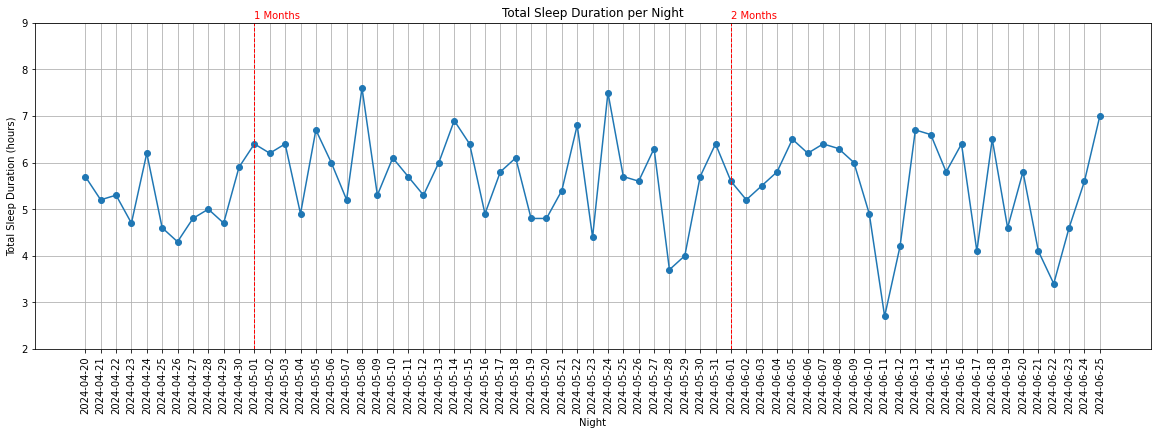

In [17]:
plt.figure(figsize=(20, 6))
plt.plot(my_sleep_grouped["night"], my_sleep_grouped["duration_hours"], marker="o")

# Add vertical lines for "months_passed"
birthmonths = pd.date_range(start=birthdate.date(), end=my_sleep_grouped["night"].max(), freq='MS')
birthmonths = birthmonths.date.tolist()
set_nights = set(my_sleep_grouped["night"])
birthmonths_set = [item for item in birthmonths if item in set_nights]
for birthmonth in birthmonths_set:
    n_month = relativedelta(birthmonth, birthdate.date()).months
    plt.axvline(birthmonth, color="r", linestyle="--", linewidth=1)
    plt.text(
        birthmonth,
        9.1,
        f'{n_month} Months', 
        #rotation=90,
        #verticalalignment="bottom",
        fontsize=10,
        color="r")

plt.xlabel("Night")
plt.ylabel("Total Sleep Duration (hours)")
plt.title("Total Sleep Duration per Night")
plt.ylim(2, 9)
# plt.xlim(my_sleep_grouped["night"].min(), my_sleep_grouped["night"].max())
plt.grid(True)
plt.xticks(my_sleep_grouped["night"].unique(), rotation=90)
plt.show()

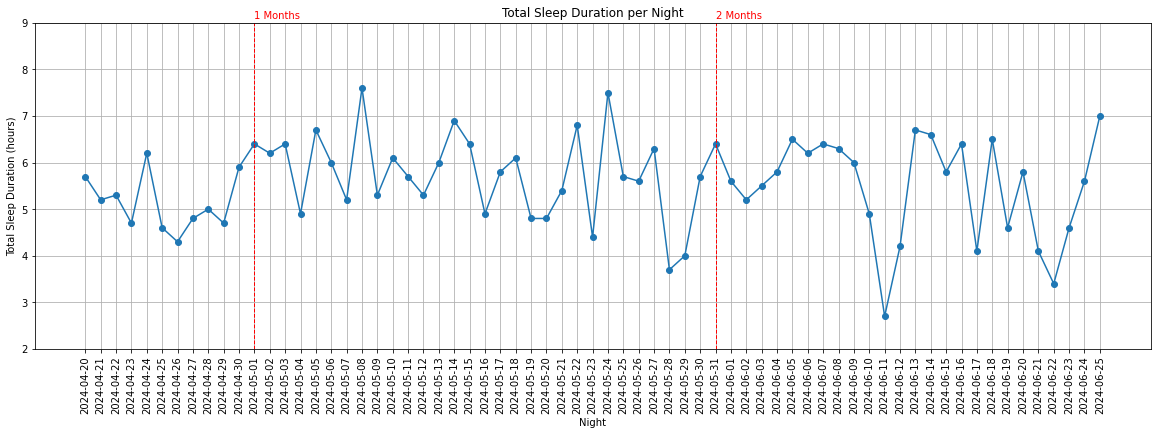

In [18]:
# Same graph with different code to add text to the plot

plt.figure(figsize=(20, 6))
plt.plot(my_sleep_grouped["night"], my_sleep_grouped["duration_hours"], marker="o")

# Add vertical lines for "months_passed"
previous_date = None
for idx, row in my_sleep_grouped.iterrows():
    if (row["months_passed"] != previous_date) and (row["months_passed"] != 0):
        plt.axvline(row["night"], color="r", linestyle="--", linewidth=1)
        plt.text(
            row["night"],
            9.1,
            f'{row["months_passed"]} Months', 
            #rotation=90,
            #verticalalignment="bottom",
            fontsize=10,
            color="r")
    previous_date = row["months_passed"]

plt.xlabel("Night")
plt.ylabel("Total Sleep Duration (hours)")
plt.title("Total Sleep Duration per Night")
plt.ylim(2, 9)
plt.grid(True)
plt.xticks(my_sleep_grouped["night"].unique(), rotation=90)
plt.show()

In [19]:
my_sleep_grouped.columns


Index(['night', 'duration_seconds', 'duration_minutes', 'duration_hours',
       'night_datetime', 'night_day', 'night_month', 'night_year',
       'night_weekday', 'night_weekday_name', 'months_passed', 'days_passed'],
      dtype='object')

## Her data  (baby sleep)

`duration` is in seconds

In [20]:
len(her_data["baby_sleep"])

546

In [21]:
her_data["baby_sleep"][:2]

[{'babyid': 1,
  'duration': 1675,
  'endDate': '2024-06-26T10:14:09.578+02:00',
  'pk': 1165,
  'note': None,
  'startDate': '2024-06-26T09:46:13.824+02:00'},
 {'babyid': 1,
  'duration': 2580,
  'endDate': '2024-06-26T07:23:00.000+02:00',
  'pk': 1163,
  'note': None,
  'startDate': '2024-06-26T06:40:00.000+02:00'}]

In [22]:
his_sleep_df = preprocess_sleep(her_data["baby_sleep"], birthdate, child=True)
his_sleep_df.head()

,duration_seconds,duration_minutes,duration_hours,endDate,startDate,start_datetime,start_day,start_month,start_year,start_hour,...,end_weekday_name,night_datetime,night,night_day,night_month,night_year,night_weekday,night_weekday_name,months_passed,days_passed
0,1675,28.0,0.5,2024-06-26T10:14:09.578+02:00,2024-06-26T09:46:13.824+02:00,2024-06-26 09:46:13.824000+02:00,26,6,2024,9,...,Wednesday,2024-06-26 09:46:13.824000+02:00,2024-06-26,26,6,2024,3,Wednesday,2,26
1,2580,43.0,0.7,2024-06-26T07:23:00.000+02:00,2024-06-26T06:40:00.000+02:00,2024-06-26 06:40:00+02:00,26,6,2024,6,...,Wednesday,2024-06-26 06:40:00+02:00,2024-06-26,26,6,2024,3,Wednesday,2,26
2,4260,71.0,1.2,2024-06-26T05:35:00.000+02:00,2024-06-26T04:24:00.000+02:00,2024-06-26 04:24:00+02:00,26,6,2024,4,...,Wednesday,2024-06-26 04:24:00+02:00,2024-06-26,26,6,2024,3,Wednesday,2,26
3,3180,53.0,0.9,2024-06-26T04:13:00.000+02:00,2024-06-26T03:20:00.000+02:00,2024-06-26 03:20:00+02:00,26,6,2024,3,...,Wednesday,2024-06-26 03:20:00+02:00,2024-06-26,26,6,2024,3,Wednesday,2,26
4,9780,163.0,2.7,2024-06-26T03:10:00.000+02:00,2024-06-26T00:27:00.000+02:00,2024-06-26 00:27:00+02:00,26,6,2024,0,...,Wednesday,2024-06-26 00:27:00+02:00,2024-06-26,26,6,2024,3,Wednesday,2,26


In [23]:
his_sleep_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 546 entries, 0 to 545
Data columns (total 32 columns):
 #   Column              Non-Null Count  Dtype                    
---  ------              --------------  -----                    
 0   duration_seconds    546 non-null    int64                    
 1   duration_minutes    546 non-null    float64                  
 2   duration_hours      546 non-null    float64                  
 3   endDate             546 non-null    object                   
 4   startDate           546 non-null    object                   
 5   start_datetime      546 non-null    datetime64[ns, UTC+02:00]
 6   start_day           546 non-null    int32                    
 7   start_month         546 non-null    int32                    
 8   start_year          546 non-null    int32                    
 9   start_hour          546 non-null    int32                    
 10  start_minute        546 non-null    int32                    
 11  start_time         

In [24]:
his_sleep_grouped = (
    his_sleep_df
    .groupby("night")
    .agg({
        "duration_seconds":"sum",
        "duration_minutes":"sum",
        "duration_hours":"sum",
        "night_datetime":"first",
        "night_day":"first",
        "night_month":"first",
        "night_year":"first",
        "night_weekday":"first",
        "night_weekday_name":"first",
        "months_passed":"first",
        "days_passed":"first"
        })
    .reset_index()
)

In [25]:
his_sleep_grouped.head()

,night,duration_seconds,duration_minutes,duration_hours,night_datetime,night_day,night_month,night_year,night_weekday,night_weekday_name,months_passed,days_passed
0,2024-04-10,12963,216.0,3.6,2024-04-10 23:37:03.729000+02:00,10,4,2024,3,Wednesday,0,11
1,2024-04-11,7304,122.0,2.0,2024-04-11 03:47:34.763000+02:00,11,4,2024,4,Thursday,0,11
2,2024-04-18,23012,384.0,6.4,2024-04-18 21:43:00+02:00,18,4,2024,4,Thursday,0,18
3,2024-04-19,13809,230.0,3.8,2024-04-19 04:47:27.010000+02:00,19,4,2024,5,Friday,0,19
4,2024-05-06,25405,423.0,7.1,2024-05-06 20:55:35.598000+02:00,6,5,2024,1,Monday,1,5


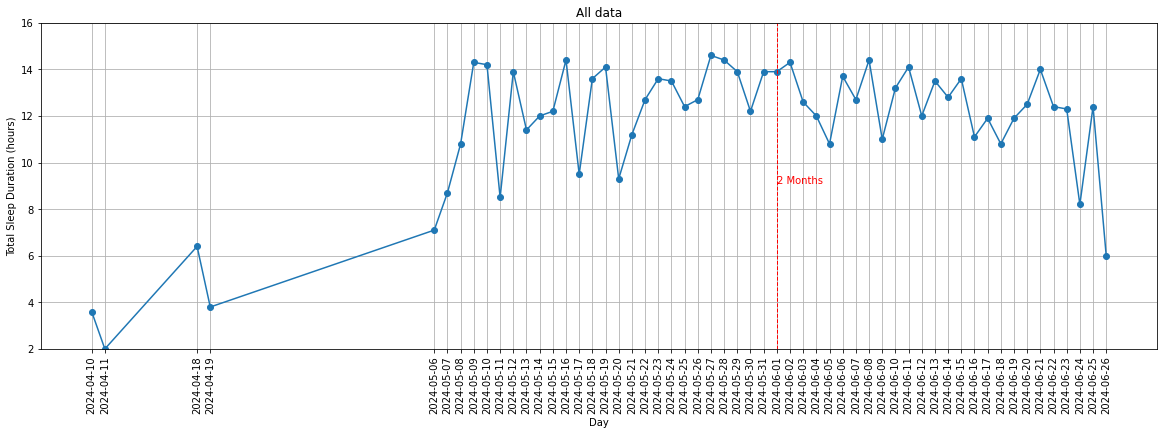

In [26]:
plt.figure(figsize=(20, 6))
plt.plot(his_sleep_grouped["night"], his_sleep_grouped["duration_hours"], marker="o")

# Add vertical lines for "months_passed"
birthmonths = pd.date_range(start=birthdate.date(), end=his_sleep_grouped["night"].max(), freq='MS')
birthmonths = birthmonths.date.tolist()
set_nights = set(his_sleep_grouped["night"])
birthmonths_set = [item for item in birthmonths if item in set_nights]
for birthmonth in birthmonths_set:
    n_month = relativedelta(birthmonth, birthdate.date()).months
    plt.axvline(birthmonth, color="r", linestyle="--", linewidth=1)
    plt.text(
        birthmonth,
        9.1,
        f'{n_month} Months', 
        #rotation=90,
        #verticalalignment="bottom",
        fontsize=10,
        color="r")

plt.xlabel("Day")
plt.ylabel("Total Sleep Duration (hours)")
plt.title("All data")
plt.ylim(2, round(max(his_sleep_grouped["duration_hours"]) + 1))
plt.grid(True)
plt.xticks(his_sleep_grouped["night"].unique(), rotation=90)
plt.show()

In [27]:
# Exclude data before the 6th of May
lower_date = pd.to_datetime("2024-05-06T00:00:00.000+02:00")
his_sleep_df_filtered = his_sleep_df[his_sleep_df["start_datetime"] > lower_date]

In [28]:
his_sleep_df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 534 entries, 0 to 533
Data columns (total 32 columns):
 #   Column              Non-Null Count  Dtype                    
---  ------              --------------  -----                    
 0   duration_seconds    534 non-null    int64                    
 1   duration_minutes    534 non-null    float64                  
 2   duration_hours      534 non-null    float64                  
 3   endDate             534 non-null    object                   
 4   startDate           534 non-null    object                   
 5   start_datetime      534 non-null    datetime64[ns, UTC+02:00]
 6   start_day           534 non-null    int32                    
 7   start_month         534 non-null    int32                    
 8   start_year          534 non-null    int32                    
 9   start_hour          534 non-null    int32                    
 10  start_minute        534 non-null    int32                    
 11  start_time          534 

In [29]:
his_sleep_grouped_filtered = (
    his_sleep_df_filtered
    .groupby("night")
    .agg({
        "duration_seconds":"sum",
        "duration_minutes":"sum",
        "duration_hours":"sum",
        "night_datetime":"first",
        "night_day":"first",
        "night_month":"first",
        "night_year":"first",
        "night_weekday":"first",
        "night_weekday_name":"first",
        "months_passed":"first",
        "days_passed":"first"
        })
    .reset_index()
)

In [30]:
his_sleep_grouped_filtered.head()

,night,duration_seconds,duration_minutes,duration_hours,night_datetime,night_day,night_month,night_year,night_weekday,night_weekday_name,months_passed,days_passed
0,2024-05-06,25405,423.0,7.1,2024-05-06 20:55:35.598000+02:00,6,5,2024,1,Monday,1,5
1,2024-05-07,31450,525.0,8.7,2024-05-07 21:30:00+02:00,7,5,2024,2,Tuesday,1,6
2,2024-05-08,38456,640.0,10.8,2024-05-08 23:24:19.520000+02:00,8,5,2024,3,Wednesday,1,7
3,2024-05-09,52057,868.0,14.3,2024-05-09 23:21:27.758000+02:00,9,5,2024,4,Thursday,1,8
4,2024-05-10,50139,836.0,14.2,2024-05-10 23:16:00+02:00,10,5,2024,5,Friday,1,9


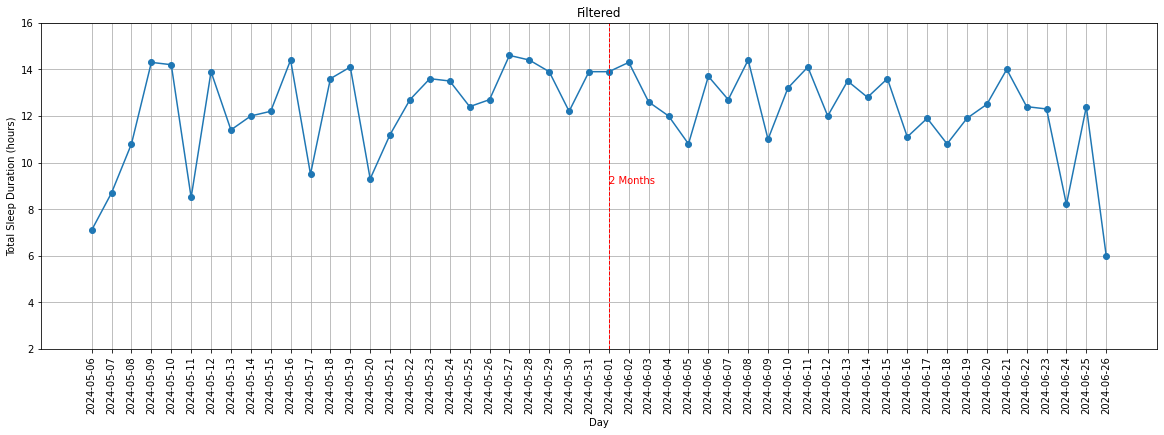

In [31]:
plt.figure(figsize=(20, 6))
plt.plot(his_sleep_grouped_filtered["night"], his_sleep_grouped_filtered["duration_hours"], marker="o")

# Add vertical lines for "months_passed"
birthmonths = pd.date_range(start=birthdate.date(), end=his_sleep_grouped_filtered["night"].max(), freq='MS')
birthmonths = birthmonths.date.tolist()
set_nights = set(his_sleep_grouped_filtered["night"])
birthmonths_set = [item for item in birthmonths if item in set_nights]
for birthmonth in birthmonths_set:
    n_month = relativedelta(birthmonth, birthdate.date()).months
    plt.axvline(birthmonth, color="r", linestyle="--", linewidth=1)
    plt.text(
        birthmonth,
        9.1,
        f'{n_month} Months', 
        #rotation=90,
        #verticalalignment="bottom",
        fontsize=10,
        color="r")

plt.xlabel("Day")
plt.ylabel("Total Sleep Duration (hours)")
plt.title("Filtered")
plt.ylim(2, round(max(his_sleep_grouped_filtered["duration_hours"]) + 1))
plt.grid(True)
plt.xticks(his_sleep_grouped_filtered["night"].unique(), rotation=90)
plt.show()

## Combine and compare sleeping data

In [32]:
df_merged = pd.merge(my_sleep_grouped, his_sleep_grouped_filtered, on="night")

In [33]:
df_merged.head()

,night,duration_seconds_x,duration_minutes_x,duration_hours_x,night_datetime_x,night_day_x,night_month_x,night_year_x,night_weekday_x,night_weekday_name_x,...,duration_minutes_y,duration_hours_y,night_datetime_y,night_day_y,night_month_y,night_year_y,night_weekday_y,night_weekday_name_y,months_passed_y,days_passed_y
0,2024-05-06,21332,356.0,6.0,2024-05-06 06:00:00+02:00,6,5,2024,1,Monday,...,423.0,7.1,2024-05-06 20:55:35.598000+02:00,6,5,2024,1,Monday,1,5
1,2024-05-07,18540,309.0,5.2,2024-05-07 04:13:05.346000+02:00,7,5,2024,2,Tuesday,...,525.0,8.7,2024-05-07 21:30:00+02:00,7,5,2024,2,Tuesday,1,6
2,2024-05-08,27696,462.0,7.6,2024-05-08 06:24:42.480000+02:00,8,5,2024,3,Wednesday,...,640.0,10.8,2024-05-08 23:24:19.520000+02:00,8,5,2024,3,Wednesday,1,7
3,2024-05-09,19125,319.0,5.3,2024-05-09 05:27:01.767000+02:00,9,5,2024,4,Thursday,...,868.0,14.3,2024-05-09 23:21:27.758000+02:00,9,5,2024,4,Thursday,1,8
4,2024-05-10,22223,371.0,6.1,2024-05-10 04:54:42.699000+02:00,10,5,2024,5,Friday,...,836.0,14.2,2024-05-10 23:16:00+02:00,10,5,2024,5,Friday,1,9


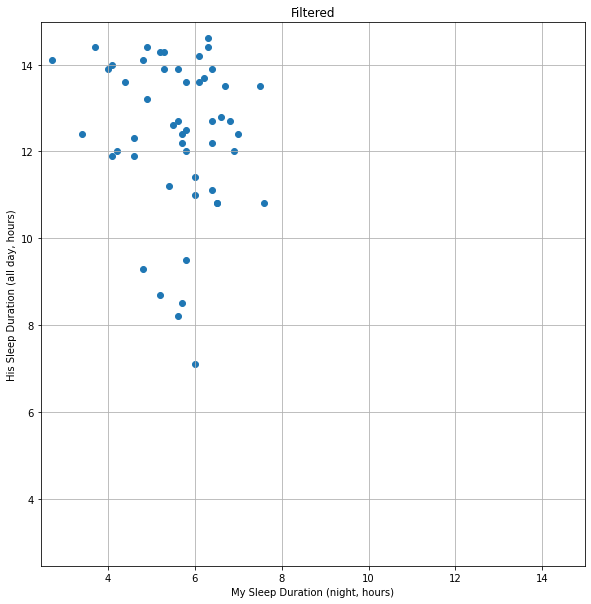

In [34]:
plt.figure(figsize=(10, 10))
plt.scatter(df_merged["duration_hours_x"], df_merged["duration_hours_y"], marker="o")
ax = plt.gca() # get the current axes instance
ax.set_aspect("equal", adjustable="box") # Set the aspect ratio to be equal
xlim = ax.get_xlim() # get the current limits for x axis
ylim = ax.get_ylim() # get the current limits for y axis
min_lim = min(xlim[0], ylim[0])
max_lim = max(xlim[1], ylim[1])
ax.set_xlim(min_lim, max_lim) # set the limits for x axis
ax.set_ylim(min_lim, max_lim) # set the limits for y axis
plt.xlabel("My Sleep Duration (night, hours)")
plt.ylabel("His Sleep Duration (all day, hours)")
plt.title("Filtered")
plt.grid(True)

plt.show()

## My data (feeding)

In [35]:
len(my_data["baby_nursingfeed"])

1119

In [36]:
my_data["baby_nursingfeed"][:2]

[{'babyid': 1,
  'endDate': '2024-06-18T11:53:08.624+02:00',
  'leftDuration': 841,
  'pk': 1139,
  'note': None,
  'nursingSide': 'left',
  'rightDuration': 0,
  'startDate': '2024-06-18T11:39:06.899+02:00',
  'startingBreast': 'left'},
 {'babyid': 1,
  'endDate': '2024-06-11T14:58:02.051+02:00',
  'leftDuration': 535,
  'pk': 1138,
  'note': None,
  'nursingSide': 'left',
  'rightDuration': 0,
  'startDate': '2024-06-11T14:49:06.853+02:00',
  'startingBreast': 'left'}]

In [37]:
print(f'Duration in Seconds: {my_data["baby_nursingfeed"][0]["leftDuration"]}')
print(f'Duration in Minutes: {my_data["baby_nursingfeed"][0]["leftDuration"] / 60}')
print(f'Duration in Hours:   {(my_data["baby_nursingfeed"][0]["leftDuration"] / 60) / 60}')

Duration in Seconds: 841
Duration in Minutes: 14.016666666666667
Duration in Hours:   0.23361111111111113


In [38]:
def preprocess_feeding(data: list[dict], birthdate:pd.Timestamp) -> pd.DataFrame:
    df = pd.DataFrame(data)
    # Duration
    df["left_duration_seconds"] = df["leftDuration"]
    df["left_duration_minutes"] = round(df["leftDuration"] / 60)
    df["left_duration_hours"] = round((df["leftDuration"] / 60) / 60, 1)
    df["right_duration_seconds"] = df["rightDuration"]
    df["right_duration_minutes"] = round(df["rightDuration"] / 60)
    df["right_duration_hours"] = round((df["rightDuration"] / 60) / 60, 1)
        
    # Extract time info for startDate
    df["start_datetime"] = pd.to_datetime(df["startDate"])
    df["start_day"] = df["start_datetime"].dt.day
    df["start_month"] = df["start_datetime"].dt.month
    df["start_year"] = df["start_datetime"].dt.year
    df["start_hour"] = df["start_datetime"].dt.hour
    df["start_minute"] = df["start_datetime"].dt.minute
    df["start_time"] = df["start_datetime"].dt.strftime("%H:%M")
    df["start_weekday"] = df["start_datetime"].dt.dayofweek + 1 # add 1 because: Monday=0, Sunday=6
    df["start_weekday_name"] = df["start_datetime"].dt.day_name()
    
    # Extract time info for endDate
    df["end_datetime"] = pd.to_datetime(df["endDate"])
    df["end_day"] = df["end_datetime"].dt.day
    df["end_month"] = df["end_datetime"].dt.month
    df["end_year"] = df["end_datetime"].dt.year
    df["end_hour"] = df["end_datetime"].dt.hour
    df["end_minute"] = df["end_datetime"].dt.minute
    df["end_time"] = df["end_datetime"].dt.strftime("%H:%M")
    df["end_weekday"] = df["end_datetime"].dt.dayofweek + 1 # add 1 because: Monday=0, Sunday=6
    df["end_weekday_name"] = df["end_datetime"].dt.day_name()

    # day
    df["day"] = df["start_datetime"].dt.date

    # Add months and days passed
    df[["months_passed", "days_passed"]] = [calculate_months_days(days, birthdate) for days in df["start_datetime"]]

    # Select relevant columns
    columns_to_keep = [
        "left_duration_seconds", "left_duration_minutes", "left_duration_hours",
        "right_duration_seconds", "right_duration_minutes", "right_duration_hours",
        "endDate", "startDate",
        "start_datetime", "start_day", "start_month", "start_year", "start_hour",
        "start_minute", "start_time", "start_weekday", "start_weekday_name",
        "end_datetime", "end_day", "end_month", "end_year", "end_hour",
        "end_minute", "end_time", "end_weekday", "end_weekday_name",
        "day", "months_passed", "days_passed"
        ]
    
    return df[columns_to_keep]

In [39]:
feeding_df_mydata = preprocess_feeding(my_data["baby_nursingfeed"], birthdate)
feeding_df_mydata.head()

,left_duration_seconds,left_duration_minutes,left_duration_hours,right_duration_seconds,right_duration_minutes,right_duration_hours,endDate,startDate,start_datetime,start_day,...,end_month,end_year,end_hour,end_minute,end_time,end_weekday,end_weekday_name,day,months_passed,days_passed
0,841,14.0,0.2,0,0.0,0.0,2024-06-18T11:53:08.624+02:00,2024-06-18T11:39:06.899+02:00,2024-06-18 11:39:06.899000+02:00,18,...,6,2024,11,53,11:53,2,Tuesday,2024-06-18,2,18
1,535,9.0,0.1,0,0.0,0.0,2024-06-11T14:58:02.051+02:00,2024-06-11T14:49:06.853+02:00,2024-06-11 14:49:06.853000+02:00,11,...,6,2024,14,58,14:58,2,Tuesday,2024-06-11,2,11
2,295,5.0,0.1,0,0.0,0.0,2024-06-10T20:55:32.314+02:00,2024-06-10T20:50:36.804+02:00,2024-06-10 20:50:36.804000+02:00,10,...,6,2024,20,55,20:55,1,Monday,2024-06-10,2,10
3,926,15.0,0.3,0,0.0,0.0,2024-06-08T23:43:16.545+02:00,2024-06-08T23:27:50.409+02:00,2024-06-08 23:27:50.409000+02:00,8,...,6,2024,23,43,23:43,6,Saturday,2024-06-08,2,8
4,0,0.0,0.0,600,10.0,0.2,2024-06-08T20:10:00.000+02:00,2024-06-08T20:00:00.000+02:00,2024-06-08 20:00:00+02:00,8,...,6,2024,20,10,20:10,6,Saturday,2024-06-08,2,8


In [40]:
feeding_df_mydata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1119 entries, 0 to 1118
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype                    
---  ------                  --------------  -----                    
 0   left_duration_seconds   1119 non-null   int64                    
 1   left_duration_minutes   1119 non-null   float64                  
 2   left_duration_hours     1119 non-null   float64                  
 3   right_duration_seconds  1119 non-null   int64                    
 4   right_duration_minutes  1119 non-null   float64                  
 5   right_duration_hours    1119 non-null   float64                  
 6   endDate                 1119 non-null   object                   
 7   startDate               1119 non-null   object                   
 8   start_datetime          1119 non-null   datetime64[ns, UTC+02:00]
 9   start_day               1119 non-null   int32                    
 10  start_month             1119 non-nul

In [41]:
feeding_df_mydata_grouped = (
    feeding_df_mydata
    .groupby("day")
    .agg(
        left_duration_seconds=pd.NamedAgg(column="left_duration_seconds", aggfunc="sum"),
        left_duration_minutes=pd.NamedAgg(column="left_duration_minutes", aggfunc="sum"),
        left_duration_hours=pd.NamedAgg(column="left_duration_hours", aggfunc="sum"),
        right_duration_seconds=pd.NamedAgg(column="right_duration_seconds", aggfunc="sum"),
        right_duration_minutes=pd.NamedAgg(column="right_duration_minutes", aggfunc="sum"),
        right_duration_hours=pd.NamedAgg(column="right_duration_hours", aggfunc="sum"),
        start_datetime=pd.NamedAgg(column="start_datetime", aggfunc="first"),
        start_day=pd.NamedAgg(column="start_day", aggfunc="first"),
        start_month=pd.NamedAgg(column="start_month", aggfunc="first"),
        start_year=pd.NamedAgg(column="start_year", aggfunc="first"),
        start_weekday=pd.NamedAgg(column="start_weekday", aggfunc="first"),
        start_weekday_name=pd.NamedAgg(column="start_weekday_name", aggfunc="first"),
        months_passed=pd.NamedAgg(column="months_passed", aggfunc="first"),
        days_passed=pd.NamedAgg(column="days_passed", aggfunc="first"),
        count=pd.NamedAgg(column="start_day", aggfunc="count"),
    )
    .reset_index()
)

In [42]:
feeding_df_mydata_grouped.head()

,day,left_duration_seconds,left_duration_minutes,left_duration_hours,right_duration_seconds,right_duration_minutes,right_duration_hours,start_datetime,start_day,start_month,start_year,start_weekday,start_weekday_name,months_passed,days_passed,count
0,2024-04-04,5650,94.0,1.7,5552,92.0,1.7,2024-04-04 23:50:36.153000+02:00,4,4,2024,4,Thursday,0,5,12
1,2024-04-05,7258,122.0,2.1,5447,91.0,1.6,2024-04-05 21:56:33.685000+02:00,5,4,2024,5,Friday,0,5,16
2,2024-04-06,10083,168.0,2.6,12086,201.0,3.4,2024-04-06 23:49:11.141000+02:00,6,4,2024,6,Saturday,0,7,27
3,2024-04-07,5435,90.0,1.4,10632,178.0,3.0,2024-04-07 23:29:50.565000+02:00,7,4,2024,7,Sunday,0,7,21
4,2024-04-08,14560,242.0,4.0,10044,166.0,2.7,2024-04-08 23:37:41.765000+02:00,8,4,2024,1,Monday,0,9,33


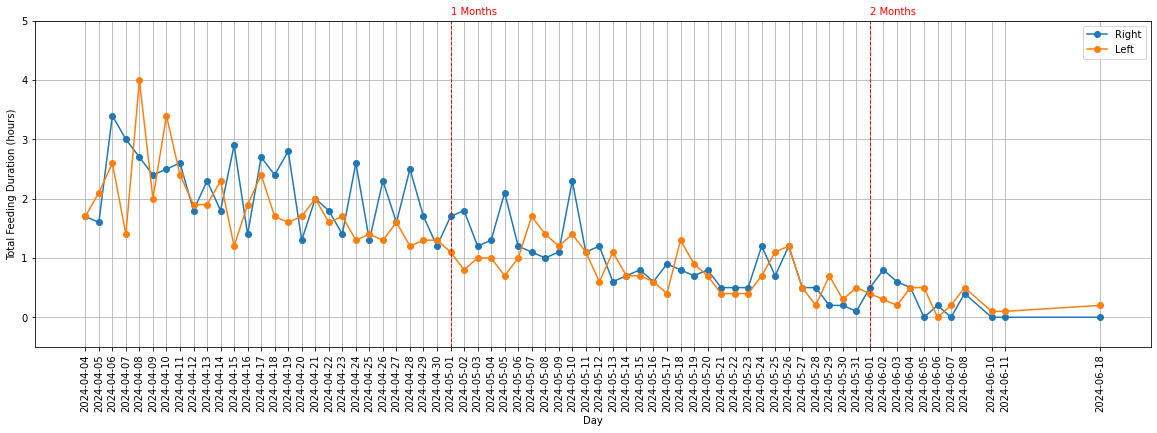

In [43]:
plt.figure(figsize=(20, 6))
plt.plot(feeding_df_mydata_grouped["day"], feeding_df_mydata_grouped["right_duration_hours"], marker="o", label="Right")
plt.plot(feeding_df_mydata_grouped["day"], feeding_df_mydata_grouped["left_duration_hours"], marker="o", label="Left")

# Add vertical lines for "months_passed"
birthmonths = pd.date_range(start=birthdate.date(), end=feeding_df_mydata_grouped["day"].max(), freq='MS')
birthmonths = birthmonths.date.tolist()
set_nights = set(feeding_df_mydata_grouped["day"])
birthmonths_set = [item for item in birthmonths if item in set_nights]
for birthmonth in birthmonths_set:
    n_month = relativedelta(birthmonth, birthdate.date()).months
    plt.axvline(birthmonth, color="r", linestyle="--", linewidth=1)
    plt.text(
        birthmonth,
        y=round(
                max(
                    max(feeding_df_mydata_grouped["left_duration_hours"]),
                    max(feeding_df_mydata_grouped["right_duration_hours"])
                )
            ) + 1.1,
        s=f'{n_month} Months', 
        #rotation=90,
        #verticalalignment="bottom",
        fontsize=10,
        color="r")

plt.xlabel("Day")
plt.ylabel("Total Feeding Duration (hours)")
# plt.title("Total Feeding Duration per Night")
plt.legend()
plt.ylim(
    -0.5,
    round(
        max(
            max(feeding_df_mydata_grouped["left_duration_hours"]),
            max(feeding_df_mydata_grouped["right_duration_hours"])
        )
    ) + 1    
)
plt.grid(True)
plt.xticks(feeding_df_mydata_grouped["day"].unique(), rotation=90)
plt.show()


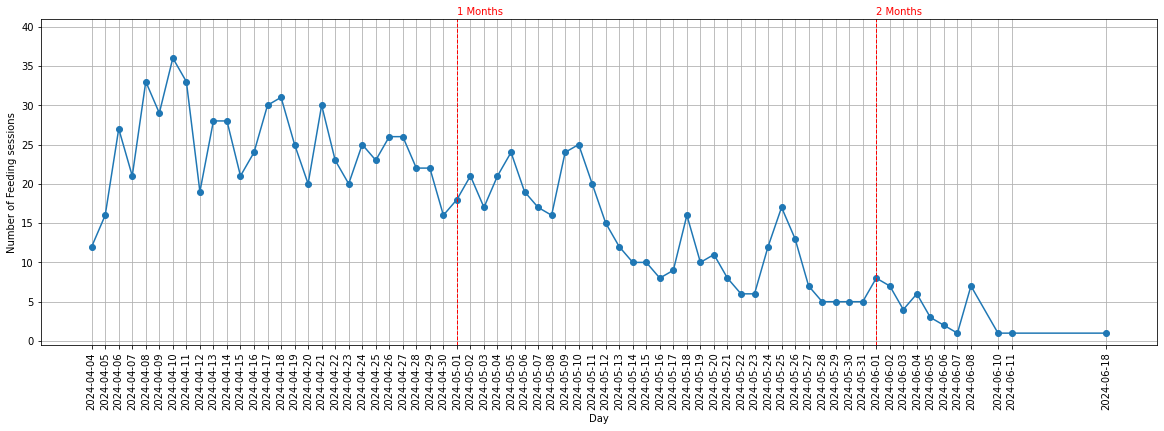

In [44]:
plt.figure(figsize=(20, 6))
plt.plot(feeding_df_mydata_grouped["day"], feeding_df_mydata_grouped["count"], marker="o")

# Add vertical lines for "months_passed"
birthmonths = pd.date_range(start=birthdate.date(), end=feeding_df_mydata_grouped["day"].max(), freq='MS')
birthmonths = birthmonths.date.tolist()
set_nights = set(feeding_df_mydata_grouped["day"])
birthmonths_set = [item for item in birthmonths if item in set_nights]
for birthmonth in birthmonths_set:
    n_month = relativedelta(birthmonth, birthdate.date()).months
    plt.axvline(birthmonth, color="r", linestyle="--", linewidth=1)
    plt.text(
        birthmonth,
        y=round(max(feeding_df_mydata_grouped["count"])) + 5.5,
        s=f'{n_month} Months', 
        #rotation=90,
        #verticalalignment="bottom",
        fontsize=10,
        color="r")

plt.xlabel("Day")
plt.ylabel("Number of Feeding sessions")
plt.ylim(
    -0.5,
    round(max(feeding_df_mydata_grouped["count"])) + 5    
)
plt.grid(True)
plt.xticks(feeding_df_mydata_grouped["day"].unique(), rotation=90)
plt.show()


## Her data (feeding)

In [45]:
len(her_data["baby_nursingfeed"])

898

In [46]:
feeding_df_herdata = preprocess_feeding(her_data["baby_nursingfeed"], birthdate)
feeding_df_herdata.head()

,left_duration_seconds,left_duration_minutes,left_duration_hours,right_duration_seconds,right_duration_minutes,right_duration_hours,endDate,startDate,start_datetime,start_day,...,end_month,end_year,end_hour,end_minute,end_time,end_weekday,end_weekday_name,day,months_passed,days_passed
0,1003,17.0,0.3,0,0.0,0.0,2024-06-26T11:56:46.307+02:00,2024-06-26T11:40:02.786+02:00,2024-06-26 11:40:02.786000+02:00,26,...,6,2024,11,56,11:56,3,Wednesday,2024-06-26,2,26
1,0,0.0,0.0,124,2.0,0.0,2024-06-26T11:23:27.546+02:00,2024-06-26T11:21:22.927+02:00,2024-06-26 11:21:22.927000+02:00,26,...,6,2024,11,23,11:23,3,Wednesday,2024-06-26,2,26
2,0,0.0,0.0,155,3.0,0.0,2024-06-26T11:20:50.488+02:00,2024-06-26T11:18:14.995+02:00,2024-06-26 11:18:14.995000+02:00,26,...,6,2024,11,20,11:20,3,Wednesday,2024-06-26,2,26
3,849,14.0,0.2,0,0.0,0.0,2024-06-26T09:46:09.126+02:00,2024-06-26T09:32:00.000+02:00,2024-06-26 09:32:00+02:00,26,...,6,2024,9,46,09:46,3,Wednesday,2024-06-26,2,26
4,60,1.0,0.0,0,0.0,0.0,2024-06-26T09:07:00.000+02:00,2024-06-26T09:06:00.000+02:00,2024-06-26 09:06:00+02:00,26,...,6,2024,9,7,09:07,3,Wednesday,2024-06-26,2,26


In [47]:
feeding_df_herdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 898 entries, 0 to 897
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype                    
---  ------                  --------------  -----                    
 0   left_duration_seconds   898 non-null    int64                    
 1   left_duration_minutes   898 non-null    float64                  
 2   left_duration_hours     898 non-null    float64                  
 3   right_duration_seconds  898 non-null    int64                    
 4   right_duration_minutes  898 non-null    float64                  
 5   right_duration_hours    898 non-null    float64                  
 6   endDate                 898 non-null    object                   
 7   startDate               898 non-null    object                   
 8   start_datetime          898 non-null    datetime64[ns, UTC+02:00]
 9   start_day               898 non-null    int32                    
 10  start_month             898 non-null  

In [48]:
feeding_df_herdata_grouped = (
    feeding_df_herdata
    .groupby("day")
    .agg(
        left_duration_seconds=pd.NamedAgg(column="left_duration_seconds", aggfunc="sum"),
        left_duration_minutes=pd.NamedAgg(column="left_duration_minutes", aggfunc="sum"),
        left_duration_hours=pd.NamedAgg(column="left_duration_hours", aggfunc="sum"),
        right_duration_seconds=pd.NamedAgg(column="right_duration_seconds", aggfunc="sum"),
        right_duration_minutes=pd.NamedAgg(column="right_duration_minutes", aggfunc="sum"),
        right_duration_hours=pd.NamedAgg(column="right_duration_hours", aggfunc="sum"),
        start_datetime=pd.NamedAgg(column="start_datetime", aggfunc="first"),
        start_day=pd.NamedAgg(column="start_day", aggfunc="first"),
        start_month=pd.NamedAgg(column="start_month", aggfunc="first"),
        start_year=pd.NamedAgg(column="start_year", aggfunc="first"),
        start_weekday=pd.NamedAgg(column="start_weekday", aggfunc="first"),
        start_weekday_name=pd.NamedAgg(column="start_weekday_name", aggfunc="first"),
        months_passed=pd.NamedAgg(column="months_passed", aggfunc="first"),
        days_passed=pd.NamedAgg(column="days_passed", aggfunc="first"),
        count=pd.NamedAgg(column="start_day", aggfunc="count"),
    )
    .reset_index()
)

In [49]:
feeding_df_herdata_grouped.head()

,day,left_duration_seconds,left_duration_minutes,left_duration_hours,right_duration_seconds,right_duration_minutes,right_duration_hours,start_datetime,start_day,start_month,start_year,start_weekday,start_weekday_name,months_passed,days_passed,count
0,2024-04-09,746,12.0,0.2,3089,51.0,1.0,2024-04-09 22:00:16.085000+02:00,9,4,2024,2,Tuesday,0,9,8
1,2024-04-10,99204,1651.0,27.6,11769,196.0,3.3,2024-04-10 23:05:33.030000+02:00,10,4,2024,3,Wednesday,0,10,31
2,2024-05-06,1501,25.0,0.4,2684,45.0,0.9,2024-05-06 20:34:42.241000+02:00,6,5,2024,1,Monday,1,5,9
3,2024-05-07,300,5.0,0.1,1198,20.0,0.3,2024-05-07 02:43:30.877000+02:00,7,5,2024,2,Tuesday,1,6,2
4,2024-05-08,515,9.0,0.1,0,0.0,0.0,2024-05-08 23:15:14.854000+02:00,8,5,2024,3,Wednesday,1,7,1


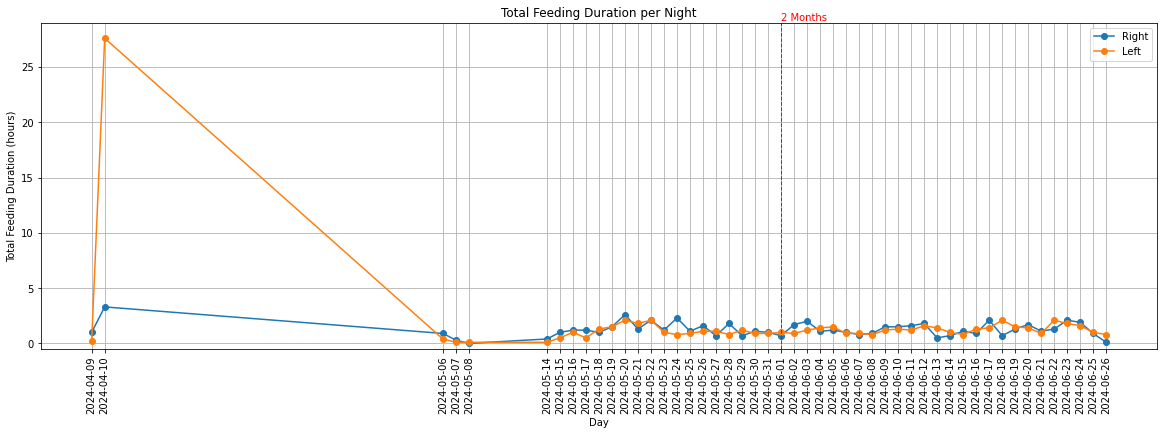

In [50]:
plt.figure(figsize=(20, 6))
plt.plot(feeding_df_herdata_grouped["day"], feeding_df_herdata_grouped["right_duration_hours"], marker="o", label="Right")
plt.plot(feeding_df_herdata_grouped["day"], feeding_df_herdata_grouped["left_duration_hours"], marker="o", label="Left")

# Add vertical lines for "months_passed"
birthmonths = pd.date_range(start=birthdate.date(), end=feeding_df_herdata_grouped["day"].max(), freq='MS')
birthmonths = birthmonths.date.tolist()
set_nights = set(feeding_df_herdata_grouped["day"])
birthmonths_set = [item for item in birthmonths if item in set_nights]
for birthmonth in birthmonths_set:
    n_month = relativedelta(birthmonth, birthdate.date()).months
    plt.axvline(birthmonth, color="r", linestyle="--", linewidth=1)
    plt.text(
        birthmonth,
        y=round(
                max(
                    max(feeding_df_herdata_grouped["left_duration_hours"]),
                    max(feeding_df_herdata_grouped["right_duration_hours"])
                )
            ) + 1.2,
        s=f'{n_month} Months', 
        #rotation=90,
        #verticalalignment="bottom",
        fontsize=10,
        color="r")

plt.xlabel("Day")
plt.ylabel("Total Feeding Duration (hours)")
plt.title("Total Feeding Duration per Night")
plt.legend()
plt.ylim(
    -0.5,
    round(
        max(
            max(feeding_df_herdata_grouped["left_duration_hours"]),
            max(feeding_df_herdata_grouped["right_duration_hours"])
        )
    ) + 1    
)
plt.grid(True)
plt.xticks(feeding_df_herdata_grouped["day"].unique(), rotation=90)
plt.show()


In [51]:
# Exclude data before the 6th of May
lower_date_feeding = pd.to_datetime("2024-05-06T00:00:00.000+02:00")
feeding_df_herdata_filtered = feeding_df_herdata[feeding_df_herdata["start_datetime"] > lower_date_feeding]

In [52]:
feeding_df_herdata_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 859 entries, 0 to 858
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype                    
---  ------                  --------------  -----                    
 0   left_duration_seconds   859 non-null    int64                    
 1   left_duration_minutes   859 non-null    float64                  
 2   left_duration_hours     859 non-null    float64                  
 3   right_duration_seconds  859 non-null    int64                    
 4   right_duration_minutes  859 non-null    float64                  
 5   right_duration_hours    859 non-null    float64                  
 6   endDate                 859 non-null    object                   
 7   startDate               859 non-null    object                   
 8   start_datetime          859 non-null    datetime64[ns, UTC+02:00]
 9   start_day               859 non-null    int32                    
 10  start_month             859 non-null    int

In [53]:
feeding_df_herdata_grouped_filtered = (
    feeding_df_herdata_filtered
    .groupby("day")
    .agg(
        left_duration_seconds=pd.NamedAgg(column="left_duration_seconds", aggfunc="sum"),
        left_duration_minutes=pd.NamedAgg(column="left_duration_minutes", aggfunc="sum"),
        left_duration_hours=pd.NamedAgg(column="left_duration_hours", aggfunc="sum"),
        right_duration_seconds=pd.NamedAgg(column="right_duration_seconds", aggfunc="sum"),
        right_duration_minutes=pd.NamedAgg(column="right_duration_minutes", aggfunc="sum"),
        right_duration_hours=pd.NamedAgg(column="right_duration_hours", aggfunc="sum"),
        start_datetime=pd.NamedAgg(column="start_datetime", aggfunc="first"),
        start_day=pd.NamedAgg(column="start_day", aggfunc="first"),
        start_month=pd.NamedAgg(column="start_month", aggfunc="first"),
        start_year=pd.NamedAgg(column="start_year", aggfunc="first"),
        start_weekday=pd.NamedAgg(column="start_weekday", aggfunc="first"),
        start_weekday_name=pd.NamedAgg(column="start_weekday_name", aggfunc="first"),
        months_passed=pd.NamedAgg(column="months_passed", aggfunc="first"),
        days_passed=pd.NamedAgg(column="days_passed", aggfunc="first"),
        count=pd.NamedAgg(column="start_day", aggfunc="count"),
    )
    .reset_index()
)

In [54]:
feeding_df_herdata_grouped_filtered.head()

,day,left_duration_seconds,left_duration_minutes,left_duration_hours,right_duration_seconds,right_duration_minutes,right_duration_hours,start_datetime,start_day,start_month,start_year,start_weekday,start_weekday_name,months_passed,days_passed,count
0,2024-05-06,1501,25.0,0.4,2684,45.0,0.9,2024-05-06 20:34:42.241000+02:00,6,5,2024,1,Monday,1,5,9
1,2024-05-07,300,5.0,0.1,1198,20.0,0.3,2024-05-07 02:43:30.877000+02:00,7,5,2024,2,Tuesday,1,6,2
2,2024-05-08,515,9.0,0.1,0,0.0,0.0,2024-05-08 23:15:14.854000+02:00,8,5,2024,3,Wednesday,1,7,1
3,2024-05-14,307,5.0,0.1,1416,24.0,0.4,2024-05-14 20:02:51.158000+02:00,14,5,2024,2,Tuesday,1,13,3
4,2024-05-15,1518,25.0,0.5,3350,56.0,1.0,2024-05-15 23:56:05.005000+02:00,15,5,2024,3,Wednesday,1,15,12


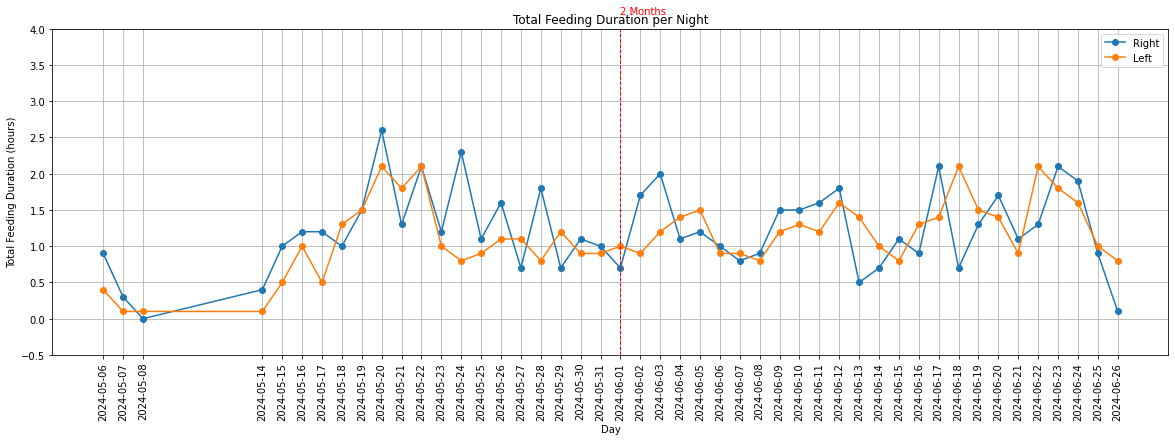

In [55]:
plt.figure(figsize=(20, 6))
plt.plot(feeding_df_herdata_grouped_filtered["day"], feeding_df_herdata_grouped_filtered["right_duration_hours"], marker="o", label="Right")
plt.plot(feeding_df_herdata_grouped_filtered["day"], feeding_df_herdata_grouped_filtered["left_duration_hours"], marker="o", label="Left")

# Add vertical lines for "months_passed"
birthmonths = pd.date_range(start=birthdate.date(), end=feeding_df_herdata_grouped_filtered["day"].max(), freq='MS')
birthmonths = birthmonths.date.tolist()
set_nights = set(feeding_df_herdata_grouped_filtered["day"])
birthmonths_set = [item for item in birthmonths if item in set_nights]
for birthmonth in birthmonths_set:
    n_month = relativedelta(birthmonth, birthdate.date()).months
    plt.axvline(birthmonth, color="r", linestyle="--", linewidth=1)
    plt.text(
        birthmonth,
        y=round(
                max(
                    max(feeding_df_herdata_grouped_filtered["left_duration_hours"]),
                    max(feeding_df_herdata_grouped_filtered["right_duration_hours"])
                )
            ) + 1.2,
        s=f'{n_month} Months', 
        #rotation=90,
        #verticalalignment="bottom",
        fontsize=10,
        color="r")

plt.xlabel("Day")
plt.ylabel("Total Feeding Duration (hours)")
plt.title("Total Feeding Duration per Night")
plt.legend()
plt.ylim(
    -0.5,
    round(
        max(
            max(feeding_df_herdata_grouped_filtered["left_duration_hours"]),
            max(feeding_df_herdata_grouped_filtered["right_duration_hours"])
        )
    ) + 1    
)
plt.grid(True)
plt.xticks(feeding_df_herdata_grouped_filtered["day"].unique(), rotation=90)
plt.show()


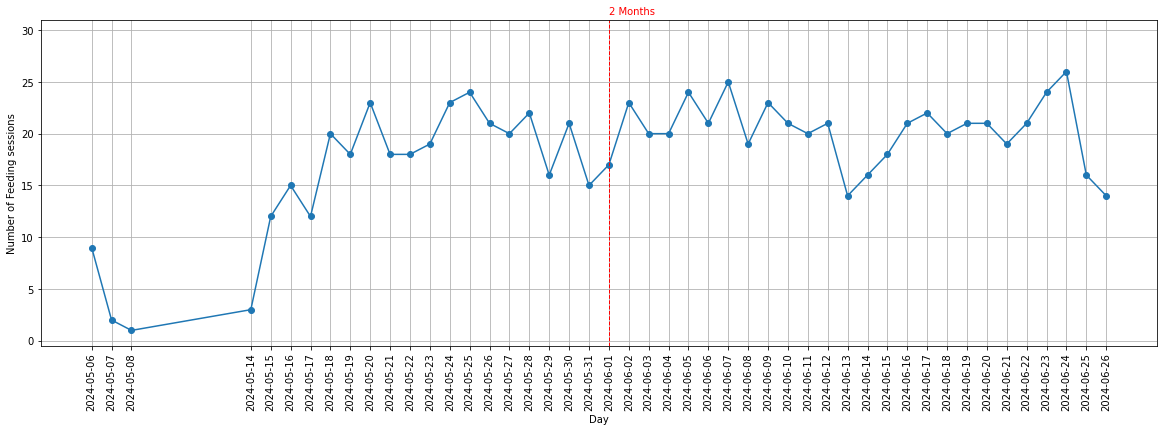

In [56]:
plt.figure(figsize=(20, 6))
plt.plot(feeding_df_herdata_grouped_filtered["day"], feeding_df_herdata_grouped_filtered["count"], marker="o")

# Add vertical lines for "months_passed"
birthmonths = pd.date_range(start=birthdate.date(), end=feeding_df_herdata_grouped_filtered["day"].max(), freq='MS')
birthmonths = birthmonths.date.tolist()
set_nights = set(feeding_df_herdata_grouped_filtered["day"])
birthmonths_set = [item for item in birthmonths if item in set_nights]
for birthmonth in birthmonths_set:
    n_month = relativedelta(birthmonth, birthdate.date()).months
    plt.axvline(birthmonth, color="r", linestyle="--", linewidth=1)
    plt.text(
        birthmonth,
        y=round(max(feeding_df_herdata_grouped_filtered["count"])) + 5.5,
        s=f'{n_month} Months', 
        #rotation=90,
        #verticalalignment="bottom",
        fontsize=10,
        color="r")

plt.xlabel("Day")
plt.ylabel("Number of Feeding sessions")
plt.ylim(
    -0.5,
    round(max(feeding_df_herdata_grouped_filtered["count"])) + 5    
)
plt.grid(True)
plt.xticks(feeding_df_herdata_grouped_filtered["day"].unique(), rotation=90)
plt.show()


## Combine feeding data

In [57]:
feeding_df_mydata.columns

Index(['left_duration_seconds', 'left_duration_minutes', 'left_duration_hours',
       'right_duration_seconds', 'right_duration_minutes',
       'right_duration_hours', 'endDate', 'startDate', 'start_datetime',
       'start_day', 'start_month', 'start_year', 'start_hour', 'start_minute',
       'start_time', 'start_weekday', 'start_weekday_name', 'end_datetime',
       'end_day', 'end_month', 'end_year', 'end_hour', 'end_minute',
       'end_time', 'end_weekday', 'end_weekday_name', 'day', 'months_passed',
       'days_passed'],
      dtype='object')

In [58]:
feeding_df_herdata_filtered.columns

Index(['left_duration_seconds', 'left_duration_minutes', 'left_duration_hours',
       'right_duration_seconds', 'right_duration_minutes',
       'right_duration_hours', 'endDate', 'startDate', 'start_datetime',
       'start_day', 'start_month', 'start_year', 'start_hour', 'start_minute',
       'start_time', 'start_weekday', 'start_weekday_name', 'end_datetime',
       'end_day', 'end_month', 'end_year', 'end_hour', 'end_minute',
       'end_time', 'end_weekday', 'end_weekday_name', 'day', 'months_passed',
       'days_passed'],
      dtype='object')

In [59]:
feeding_df_combined = pd.concat(
    [feeding_df_mydata, feeding_df_herdata_filtered],
    ignore_index=True)

In [60]:
feeding_df_combine_grouped = (
    feeding_df_combined
    .groupby("day")
    .agg(
        left_duration_seconds=pd.NamedAgg(column="left_duration_seconds", aggfunc="sum"),
        left_duration_minutes=pd.NamedAgg(column="left_duration_minutes", aggfunc="sum"),
        left_duration_hours=pd.NamedAgg(column="left_duration_hours", aggfunc="sum"),
        right_duration_seconds=pd.NamedAgg(column="right_duration_seconds", aggfunc="sum"),
        right_duration_minutes=pd.NamedAgg(column="right_duration_minutes", aggfunc="sum"),
        right_duration_hours=pd.NamedAgg(column="right_duration_hours", aggfunc="sum"),
        start_datetime=pd.NamedAgg(column="start_datetime", aggfunc="first"),
        start_day=pd.NamedAgg(column="start_day", aggfunc="first"),
        start_month=pd.NamedAgg(column="start_month", aggfunc="first"),
        start_year=pd.NamedAgg(column="start_year", aggfunc="first"),
        start_weekday=pd.NamedAgg(column="start_weekday", aggfunc="first"),
        start_weekday_name=pd.NamedAgg(column="start_weekday_name", aggfunc="first"),
        months_passed=pd.NamedAgg(column="months_passed", aggfunc="first"),
        days_passed=pd.NamedAgg(column="days_passed", aggfunc="first"),
        count=pd.NamedAgg(column="start_day", aggfunc="count"),
    )
    .reset_index()
)

In [61]:
feeding_df_combine_grouped.head()

,day,left_duration_seconds,left_duration_minutes,left_duration_hours,right_duration_seconds,right_duration_minutes,right_duration_hours,start_datetime,start_day,start_month,start_year,start_weekday,start_weekday_name,months_passed,days_passed,count
0,2024-04-04,5650,94.0,1.7,5552,92.0,1.7,2024-04-04 23:50:36.153000+02:00,4,4,2024,4,Thursday,0,5,12
1,2024-04-05,7258,122.0,2.1,5447,91.0,1.6,2024-04-05 21:56:33.685000+02:00,5,4,2024,5,Friday,0,5,16
2,2024-04-06,10083,168.0,2.6,12086,201.0,3.4,2024-04-06 23:49:11.141000+02:00,6,4,2024,6,Saturday,0,7,27
3,2024-04-07,5435,90.0,1.4,10632,178.0,3.0,2024-04-07 23:29:50.565000+02:00,7,4,2024,7,Sunday,0,7,21
4,2024-04-08,14560,242.0,4.0,10044,166.0,2.7,2024-04-08 23:37:41.765000+02:00,8,4,2024,1,Monday,0,9,33


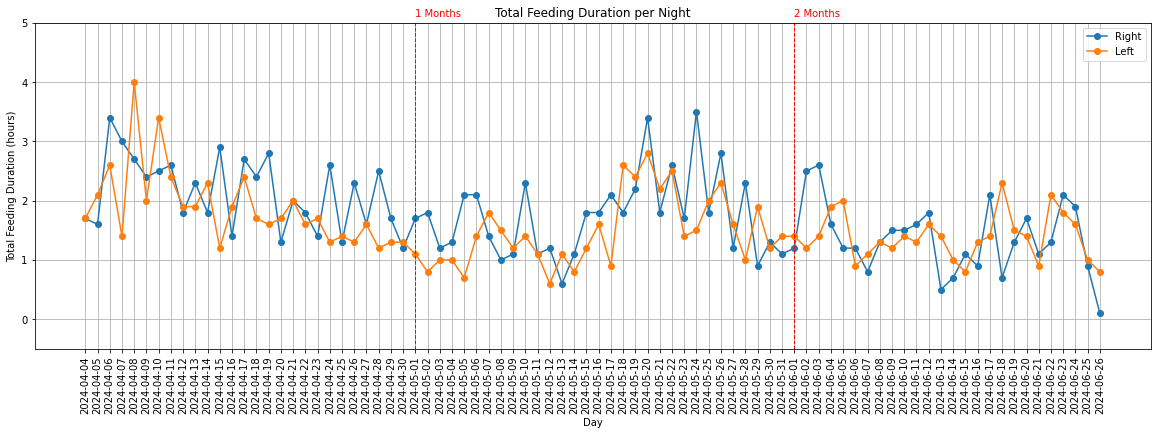

In [62]:
plt.figure(figsize=(20, 6))
plt.plot(feeding_df_combine_grouped["day"], feeding_df_combine_grouped["right_duration_hours"], marker="o", label="Right")
plt.plot(feeding_df_combine_grouped["day"], feeding_df_combine_grouped["left_duration_hours"], marker="o", label="Left")

# Add vertical lines for "months_passed"
birthmonths = pd.date_range(start=birthdate.date(), end=feeding_df_combine_grouped["day"].max(), freq='MS')
birthmonths = birthmonths.date.tolist()
set_nights = set(feeding_df_combine_grouped["day"])
birthmonths_set = [item for item in birthmonths if item in set_nights]
for birthmonth in birthmonths_set:
    n_month = relativedelta(birthmonth, birthdate.date()).months
    plt.axvline(birthmonth, color="r", linestyle="--", linewidth=1)
    plt.text(
        birthmonth,
        y=round(
                max(
                    max(feeding_df_combine_grouped["left_duration_hours"]),
                    max(feeding_df_combine_grouped["right_duration_hours"])
                )
            ) + 1.1,
        s=f'{n_month} Months', 
        #rotation=90,
        #verticalalignment="bottom",
        fontsize=10,
        color="r")

plt.xlabel("Day")
plt.ylabel("Total Feeding Duration (hours)")
plt.title("Total Feeding Duration per Night")
plt.legend()
plt.ylim(
    -0.5,
    round(
        max(
            max(feeding_df_combine_grouped["left_duration_hours"]),
            max(feeding_df_combine_grouped["right_duration_hours"])
        )
    ) + 1    
)
plt.grid(True)
plt.xticks(feeding_df_combine_grouped["day"].unique(), rotation=90)
plt.show()


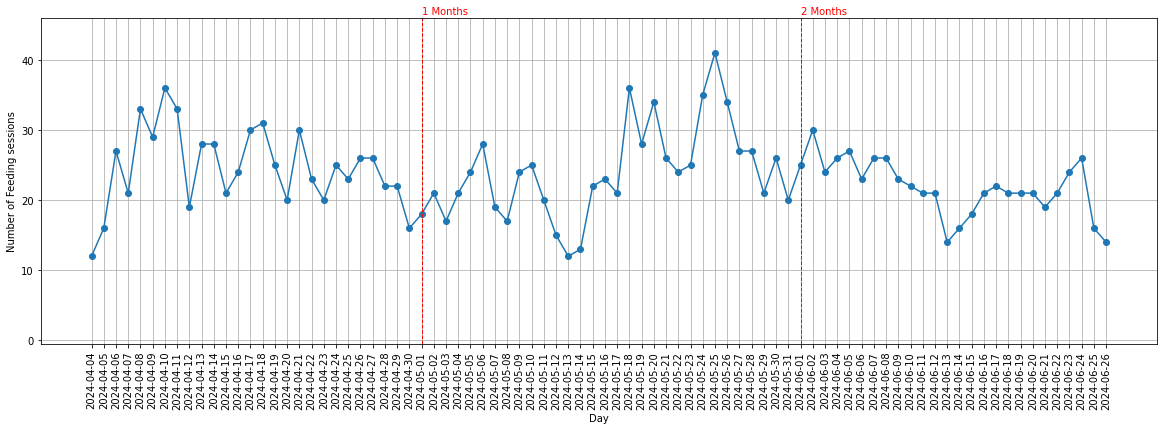

In [63]:
plt.figure(figsize=(20, 6))
plt.plot(feeding_df_combine_grouped["day"], feeding_df_combine_grouped["count"], marker="o")

# Add vertical lines for "months_passed"
birthmonths = pd.date_range(start=birthdate.date(), end=feeding_df_combine_grouped["day"].max(), freq='MS')
birthmonths = birthmonths.date.tolist()
set_nights = set(feeding_df_combine_grouped["day"])
birthmonths_set = [item for item in birthmonths if item in set_nights]
for birthmonth in birthmonths_set:
    n_month = relativedelta(birthmonth, birthdate.date()).months
    plt.axvline(birthmonth, color="r", linestyle="--", linewidth=1)
    plt.text(
        birthmonth,
        y=round(max(feeding_df_combine_grouped["count"])) + 5.5,
        s=f'{n_month} Months', 
        #rotation=90,
        #verticalalignment="bottom",
        fontsize=10,
        color="r")

plt.xlabel("Day")
plt.ylabel("Number of Feeding sessions")
plt.ylim(
    -0.5,
    round(max(feeding_df_combine_grouped["count"])) + 5    
)
plt.grid(True)
plt.xticks(feeding_df_combine_grouped["day"].unique(), rotation=90)
plt.show()
